In [1]:
%run util.py

In [2]:
data_dir = '/home/jzh/Dropbox/Research/Anomaly_Detection/ROCHM/data_dir/'

In [3]:
N = 8

In [4]:
# mu_0: the initial distribution; 1 x (N**2) 
# mu: the actual stationary distribution; 1 x (N**2)
# mu_1: the estimated stationary distribution 
# P: the new transition matrix (the old transition matrix is Q)
# G_1: the estimate of the gradient
# H_1: the estimate of the Hessian
# U_1: an estimated sample path of the Gaussian random vector U; length 1000

# P is the ground truth transition matrix
mu_0, mu, mu_1, P, G_1, H_1, U_1 = ChainGen(N)  

# PP is a different transition matrix for testing purposes
mu_0P, muP, mu_1P, PP, G_1P, H_1P, U_1P = ChainGen(N) 

zdump([N, mu_0, mu, mu_1, P, G_1, H_1, U_1, mu_0P, muP, mu_1P, PP, G_1P, H_1P, U_1P], \
      data_dir + 'P_PP_%d.pkz'%N)

<string>:372: RuntimeWarning: covariance is not positive-semidefinite.


In [5]:
N, mu_0, mu, mu_1, P, G_1, H_1, U_1, mu_0P, muP, mu_1P, PP, G_1P, H_1P, U_1P = zload(data_dir + 'P_PP_%d.pkz'%N)

In [6]:
mu

array([ 0.00212526,  0.01915574,  0.00518382,  0.02123539,  0.00115777,
        0.01489606,  0.02063686,  0.00739309,  0.02792459,  0.03411852,
        0.00537878,  0.01556394,  0.02268647,  0.00462597,  0.03559273,
        0.01786708,  0.00761418,  0.0492162 ,  0.05009707,  0.00588097,
        0.00907629,  0.01771465,  0.00473524,  0.0303655 ,  0.00983005,
        0.00692179,  0.00586676,  0.00981818,  0.02207905,  0.01902703,
        0.01321478,  0.00942148,  0.00265643,  0.03340561,  0.00855799,
        0.00178932,  0.00721895,  0.02360554,  0.00078407,  0.0053469 ,
        0.02142189,  0.00748639,  0.0291365 ,  0.01577506,  0.00589191,
        0.00439712,  0.00327651,  0.06263106,  0.00308794,  0.00849487,
        0.02934827,  0.0030242 ,  0.00398225,  0.0429937 ,  0.0006191 ,
        0.00060161,  0.01712367,  0.00495895,  0.04113092,  0.02309205,
        0.0112721 ,  0.02275637,  0.01329265,  0.01441883])

In [7]:
muP

array([ 0.00087533,  0.02749579,  0.02761133,  0.00203952,  0.0167732 ,
        0.01462217,  0.00680982,  0.00761414,  0.01574233,  0.00328237,
        0.01786833,  0.00261992,  0.01686639,  0.01879117,  0.00307924,
        0.04362312,  0.00286653,  0.02022794,  0.00864219,  0.02314051,
        0.00168083,  0.0027547 ,  0.05152436,  0.00274106,  0.01464743,
        0.01106941,  0.01236004,  0.00510011,  0.0175267 ,  0.00067135,
        0.00431794,  0.00241719,  0.01652349,  0.0188415 ,  0.00392861,
        0.00860634,  0.04918406,  0.03583127,  0.03212726,  0.00706039,
        0.02128814,  0.01205756,  0.02256261,  0.01945641,  0.00339388,
        0.00125678,  0.02209471,  0.01358354,  0.02016059,  0.02433522,
        0.0154054 ,  0.00302708,  0.03166763,  0.02322846,  0.01469619,
        0.04072926,  0.01173746,  0.00456309,  0.00519962,  0.00412028,
        0.03501023,  0.01853772,  0.0386003 ,  0.01378245])

In [8]:
n = 200
beta_1 = 0.2

In [9]:
num_test_sample = 2000

In [10]:
eta_wc = {}
eta_Sanov = {}
negative_sample = {}
positive_sample = {}

# Get sample paths of the Markov chain with length n; 
# these paths will be the test set
for idx in range(int(num_test_sample/2)):
    negative_sample[idx] = chain(mu, P, n)
for idx in range(int(num_test_sample/2)):
    positive_sample[idx] = chain(muP, PP, n)
    
# Get thresholds for Hoeffding's test corresponding to sample length n    
key = str(n) + '_' + str(beta_1)
eta_1 = ThresWeakConv(N, beta_1, n, mu_0, mu, mu_1, P, G_1, H_1, U_1).ThresCal()
eta_2 = ThresSanov(N, beta_1, n, mu_0, mu, mu_1, P, G_1, H_1, U_1).ThresCal()
eta_wc[key] = eta_1
eta_Sanov[key] = eta_2

zdump([negative_sample, positive_sample, eta_wc, eta_Sanov], data_dir + 'testSample_threshold_%d.pkz'%N)

In [11]:
negative_sample, positive_sample, eta_wc, eta_Sanov = zload(data_dir + 'testSample_threshold_%d.pkz'%N)

In [12]:
len(negative_sample[0]), eta_wc, eta_Sanov

(200, {'200_0.2': 0.16428189402312912}, {'200_0.2': 0.0080471895621705})

In [13]:
from __future__ import division

mu = np.reshape(mu, (N, N))

key = str(n) + '_' + str(beta_1)

negative_sample_KL = {}
positive_sample_KL = {}

negative_sample_wc = {}
negative_sample_sv = {}

positive_sample_wc = {}
positive_sample_sv = {}

for idx in range(int(num_test_sample/2)):
    negative_sample_KL[idx] = KL_est(negative_sample[idx], mu)
    if negative_sample_KL[idx] > eta_wc[key]:
        negative_sample_wc[idx] = 1
    else:
        negative_sample_wc[idx] = -1
    if negative_sample_KL[idx] > eta_Sanov[key]:
        negative_sample_sv[idx] = 1
    else:
        negative_sample_sv[idx] = -1    
    
    
for idx in range(int(num_test_sample/2)):
    positive_sample_KL[idx] = KL_est(positive_sample[idx], mu)
    if positive_sample_KL[idx] > eta_wc[key]:
        positive_sample_wc[idx] = 1
    else:
        positive_sample_wc[idx] = -1
    if positive_sample_KL[idx] > eta_Sanov[key]:
        positive_sample_sv[idx] = 1
    else:
        positive_sample_sv[idx] = -1 

In [14]:
def count_one(x):
    s = 0
    for idx in range(len(x)):
        if x[idx] == 1:
            s += 1
    return s, len(x) - s

In [15]:
positive_sample_len_list = range(10, 1000, 10)

TPR_wc = []

for real_pos in positive_sample_len_list:
    x = [positive_sample_wc[idx] for idx in range(real_pos)]
    s, _ = count_one(x)
    TPR_wc.append(s / real_pos)
    
# TPR_wc.append(0)
# TPR_wc.append(1)

TPR_wc = list(set(TPR_wc))

TPR_wc.sort()
TPR_wc

[1.0]

In [16]:
negative_sample_len_list = range(10, 1000, 10)

FPR_wc = []

for real_neg in negative_sample_len_list:
    x = [negative_sample_wc[idx] for idx in range(real_neg)]
    s, _ = count_one(x)
    FPR_wc.append(s / real_neg)

# FPR_wc.append(0)
# FPR_wc.append(1)

FPR_wc = list(set(FPR_wc))

FPR_wc.sort()
FPR_wc

[0.25,
 0.27647058823529413,
 0.27714285714285714,
 0.28,
 0.28055555555555556,
 0.2818181818181818,
 0.2833333333333333,
 0.284375,
 0.285,
 0.2864864864864865,
 0.2870967741935484,
 0.2875,
 0.28846153846153844,
 0.28860759493670884,
 0.28888888888888886,
 0.2892857142857143,
 0.2894736842105263,
 0.2896103896103896,
 0.29,
 0.29012345679012347,
 0.2904255319148936,
 0.2913978494623656,
 0.2914634146341463,
 0.29157894736842105,
 0.29175257731958765,
 0.292,
 0.2923076923076923,
 0.29239130434782606,
 0.2926829268292683,
 0.29270833333333335,
 0.2927710843373494,
 0.29285714285714287,
 0.29310344827586204,
 0.29318181818181815,
 0.2932584269662921,
 0.29333333333333333,
 0.29342105263157897,
 0.29375,
 0.2938775510204082,
 0.29393939393939394,
 0.294,
 0.29404761904761906,
 0.29411764705882354,
 0.2941860465116279,
 0.2942528735632184,
 0.29444444444444445,
 0.295,
 0.29523809523809524,
 0.2952941176470588,
 0.29555555555555557,
 0.2956521739130435,
 0.2957142857142857,
 0.2957446808

In [17]:
range(100, 1100, 100)

[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

In [18]:
positive_sample_len_list = range(10, 1000, 10)

TPR_sv = []

for real_pos in positive_sample_len_list:
    x = [positive_sample_sv[idx] for idx in range(real_pos)]
    s, _ = count_one(x)
    TPR_sv.append(s / real_pos)

# TPR_sv.append(0)
# TPR_sv.append(1)

TPR_sv = list(set(TPR_sv))

TPR_sv.sort()
TPR_sv

[1.0]

In [19]:
negative_sample_len_list = range(10, 1000, 10)

FPR_sv = []

for real_neg in negative_sample_len_list:
    x = [negative_sample_sv[idx] for idx in range(real_neg)]
    s, _ = count_one(x)
    FPR_sv.append(s / real_neg)

# FPR_sv.append(0)
# FPR_sv.append(1)

FPR_sv = list(set(FPR_sv))

FPR_sv.sort()
FPR_sv

[1.0]

In [20]:
if len(TPR_sv) < len(FPR_sv):
    TPR_sv_ext = TPR_sv + [TPR_sv[-1]] * (len(FPR_sv) - len(TPR_sv))
else:
    TPR_sv_ext = TPR_sv[0:len(FPR_sv)]

In [21]:
if len(TPR_wc) < len(FPR_wc):
    TPR_wc_ext = TPR_wc + [TPR_wc[-1]] * (len(FPR_wc) - len(TPR_wc))
else:
    TPR_wc_ext = TPR_wc[0:len(FPR_wc)]

In [22]:
roc_sv_pts = [(s, t) for s, t in zip(FPR_sv, TPR_sv_ext)]

In [23]:
roc_wc_pts = [(s, t) for s, t in zip(FPR_wc, TPR_wc_ext)]

In [24]:
len(FPR_wc), len(TPR_wc_ext), len(roc_wc_pts)

(84, 84, 84)

In [25]:
roc_sv_pts, roc_wc_pts

([(1.0, 1.0)],
 [(0.25, 1.0),
  (0.27647058823529413, 1.0),
  (0.27714285714285714, 1.0),
  (0.28, 1.0),
  (0.28055555555555556, 1.0),
  (0.2818181818181818, 1.0),
  (0.2833333333333333, 1.0),
  (0.284375, 1.0),
  (0.285, 1.0),
  (0.2864864864864865, 1.0),
  (0.2870967741935484, 1.0),
  (0.2875, 1.0),
  (0.28846153846153844, 1.0),
  (0.28860759493670884, 1.0),
  (0.28888888888888886, 1.0),
  (0.2892857142857143, 1.0),
  (0.2894736842105263, 1.0),
  (0.2896103896103896, 1.0),
  (0.29, 1.0),
  (0.29012345679012347, 1.0),
  (0.2904255319148936, 1.0),
  (0.2913978494623656, 1.0),
  (0.2914634146341463, 1.0),
  (0.29157894736842105, 1.0),
  (0.29175257731958765, 1.0),
  (0.292, 1.0),
  (0.2923076923076923, 1.0),
  (0.29239130434782606, 1.0),
  (0.2926829268292683, 1.0),
  (0.29270833333333335, 1.0),
  (0.2927710843373494, 1.0),
  (0.29285714285714287, 1.0),
  (0.29310344827586204, 1.0),
  (0.29318181818181815, 1.0),
  (0.2932584269662921, 1.0),
  (0.29333333333333333, 1.0),
  (0.29342105263

/home/jzh/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


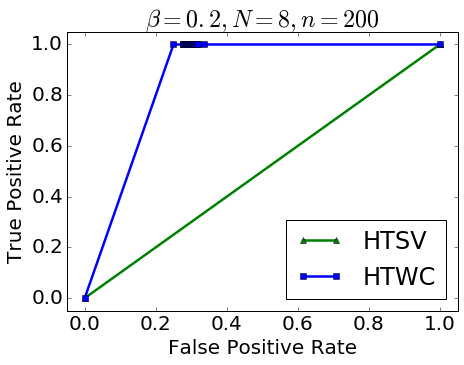

In [26]:
import matplotlib.pyplot as plt
import pylab
from pylab import *
%matplotlib inline  

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

plt.figure(figsize=(7, 5))

matplotlib.rc('font', **font)

roc_sv, = plt.plot([0] + [roc_sv_pts[idx][0] for idx in range(len(roc_sv_pts))] + [1], \
                   [0] + [roc_sv_pts[idx][1] for idx in range(len(roc_sv_pts))] + [1], "g-^", linewidth=2.5, \
                   markersize=6)
roc_wc, = plt.plot([0] + [roc_wc_pts[idx][0] for idx in range(len(roc_wc_pts))] + [1], \
                   [0] + [roc_wc_pts[idx][1] for idx in range(len(roc_wc_pts))] + [1], "b-s", linewidth=2.5, \
                  markersize=6)

plt.legend([roc_sv, roc_wc], [r"HTSV", r"HTWC"], loc=4)
plt.title(r"$\beta = %s, N = %s, n = %s$"%(beta_1, N, n))
# plt.xticks(N_list)

pylab.xlim(-0.05, 1.05)
pylab.ylim(-0.05, 1.05)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.grid()


savefig(data_dir + 'ROC_N_%s_n_%s.eps'%(N, n))

plt.show()